# Analyse et préparation des données

In [ ]:
!pip install opencv-python

In [60]:
import os
import cv2

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import numpy as np
import pandas as pd

from glob import glob

from skimage.io import imread, imshow

from sklearn.model_selection import train_test_split

from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model, Sequential
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions

In [61]:
from google.colab import drive

In [62]:
drive.mount('/gdrive')


Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [63]:
files = "/gdrive/MyDrive/brief_mask/Mask_Data"
dim = (224, 224)
X = []
y =[]
dim = (224, 224)
l=-1
for filename in os.listdir(files):
    l=l+1
    for name in os.listdir(files+'/'+filename):
        img = cv2.imread(files+'/'+filename+'/'+name)
        img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
        X.append(img)
        y.append(l)
X=np.array(X)
y=np.array(y)




In [64]:
X_train ,X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, train_size = 0.8, random_state = 42) 

## Data augmentation

In [65]:
datagen = ImageDataGenerator(rotation_range=90)
datagen.fit(X_train)
batches = 0
X_temp = []
y_temp = []
for X_batch, y_batch in datagen.flow(X_train, y_train, batch_size=9):
    X_temp.append(X_batch)
    y_temp.append(y_batch)
    #for i in range(0, 9):
    batches += 1
    if batches >= len(X_train) / 32:
        # we need to break the loop by hand because
        # the generator loops indefinitely
        break

In [66]:
c = 0
for i in range(len(X_temp)) :
    for j in range(len(X_temp[i])) :
        img = cv2.resize(X_temp[i][j], dim, interpolation = cv2.INTER_AREA)
        img=img/255.0
        print(img)
        np.append(X_train, img)
        np.append(y_train, y_temp[i][j])
        c+=1
        print(c, "done !")

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
[[[0.9607843  0.9647059  0.93730426]
  [0.9546717  0.95859325 0.9267841 ]
  [0.9207624  0.924684   0.89045274]
  ...
  [0.9701622  0.97271967 0.9676047 ]
  [0.9745986  0.9745986  0.9745986 ]
  [0.94067264 0.94067264 0.94067264]]

 [[0.9584881  0.96355784 0.9423245 ]
  [0.9607843  0.9647059  0.9386285 ]
  [0.9607843  0.9647059  0.93378425]
  ...
  [0.97985053 0.97998595 0.97971517]
  [0.9479556  0.9479556  0.9479556 ]
  [0.9435891  0.9414777  0.9435891 ]]

 [[0.9516984  0.95954156 0.9447874 ]
  [0.957164   0.9628957  0.94298667]
  [0.9607843  0.9647059  0.9399527 ]
  ...
  [0.95523864 0.95523864 0.95523864]
  [0.9416028  0.9401535  0.9416028 ]
  [0.946572   0.94265044 0.9471839 ]]

 ...

 [[0.97645986 0.9553093  0.9637134 ]
  [0.8037457  0.74866915 0.76941   ]
  [0.88883203 0.828474   0.8424552 ]
  ...
  [0.7718286  0.8456261  0.90694666]
  [0.7960495  0.8674249  0.9239013 ]
  [0.8071913  0.8761447  0.9343164 

# mise en place du modèle

In [67]:
vgg = VGG16()

In [68]:
# Modèle VGG16
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3)) 
# Freezer les couches du VGG16
for layer in base_model.layers: 
    layer.trainable = False

# Initialisation du modèle
model = Sequential()
model.add(base_model) # Ajout du modèle VGG16
model.add(Flatten()) 
model.add(Dense(4096,activation='relu'))
model.add(Dense(4096, activation='relu'))
model.add(Dense(2, activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])

In [69]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 25088)             0         
                                                                 
 dense_7 (Dense)             (None, 4096)              102764544 
                                                                 
 dense_8 (Dense)             (None, 4096)              16781312  
                                                                 
 dense_9 (Dense)             (None, 2)                 8194      
                                                                 
Total params: 134,268,738
Trainable params: 119,554,050
Non-trainable params: 14,714,688
_________________________________________________________________


In [70]:
y_train_val = tf.keras.utils.to_categorical(y_train, 2)
y_test_val = tf.keras.utils.to_categorical(y_test, 2)

In [71]:
#early_stop = EarlyStopping(monitor='val_loss',patience=2)
EPOCHS=20
batch_size = 32 
checkpoint_filepath = 'model.h5'

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_acc',
    mode='max',
    save_best_only=True)

model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(
    datagen.flow(X_train, y_train_val),
    validation_data=(X_test, y_test_val),
    epochs=EPOCHS,
    callbacks=[model_checkpoint_callback, early_stop])

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


39/39 [==============================] - 21s 516ms/step - loss: 53.6794 - accuracy: 0.7959 - val_loss: 3.3181e-04 - val_accuracy: 1.0000
Epoch 2/20
39/39 [==============================] - 20s 512ms/step - loss: 0.9969 - accuracy: 0.9828 - val_loss: 5.4417e-04 - val_accuracy: 1.0000
Epoch 3/20
39/39 [==============================] - 20s 517ms/step - loss: 0.0488 - accuracy: 0.9877 - val_loss: 2.4062e-05 - val_accuracy: 1.0000
Epoch 4/20
39/39 [==============================] - 20s 518ms/step - loss: 0.0457 - accuracy: 0.9902 - val_loss: 3.9760e-05 - val_accuracy: 1.0000
Epoch 5/20
39/39 [==============================] - 20s 511ms/step - loss: 0.0512 - accuracy: 0.9893 - val_loss: 0.0237 - val_accuracy: 0.9967


## Prédictions avec le modèle

In [72]:
preds=[]
for image in X_test :
    image = img_to_array(image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)
    prediction = model.predict(image)
    preds.append(prediction)

In [73]:
for i in range(len(preds)):
    print(preds[i])
    print("=====")

[[6.894681e-18 1.000000e+00]]
=====
[[1.0000000e+00 7.5750006e-10]]
=====
[[2.3984177e-30 1.0000000e+00]]
=====
[[1.6208267e-31 1.0000000e+00]]
=====
[[1.4463012e-18 1.0000000e+00]]
=====
[[3.5173597e-09 1.0000000e+00]]
=====
[[4.417037e-24 1.000000e+00]]
=====
[[1.0411365e-09 1.0000000e+00]]
=====
[[1.4604246e-22 1.0000000e+00]]
=====
[[1.6861198e-16 1.0000000e+00]]
=====
[[6.6521707e-15 1.0000000e+00]]
=====
[[1.4677997e-11 1.0000000e+00]]
=====
[[1.0000000e+00 6.6464993e-12]]
=====
[[3.6632345e-17 1.0000000e+00]]
=====
[[1.0000000e+00 8.8012435e-29]]
=====
[[6.255884e-08 9.999999e-01]]
=====
[[9.0803914e-27 1.0000000e+00]]
=====
[[1.000000e+00 5.026592e-15]]
=====
[[1.000000e+00 2.184388e-19]]
=====
[[1.0000000e+00 1.9949442e-31]]
=====
[[1.0000000e+00 2.0434635e-21]]
=====
[[1.0000000e+00 4.9217356e-17]]
=====
[[1.0000000e+00 3.0263313e-34]]
=====
[[7.400756e-17 1.000000e+00]]
=====
[[1.1557926e-31 1.0000000e+00]]
=====
[[1.000000e+00 4.862987e-24]]
=====
[[1.000000e+00 1.790698e-2

## Matrice de confusion du modèle

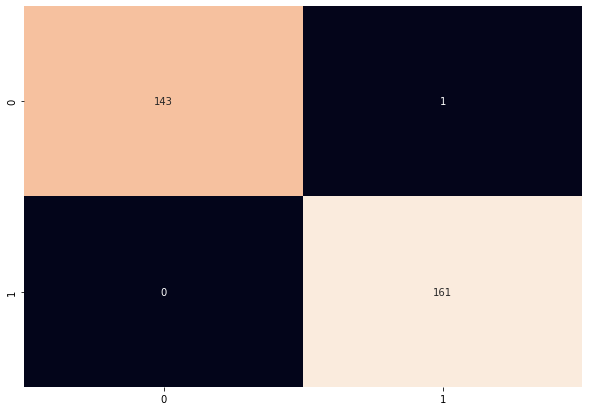

In [74]:
matrix= tf.math.confusion_matrix(
    y_test,
    np.argmax(model.predict(X_test), axis=-1),
    num_classes=2,
    weights=None,
    dtype=tf.dtypes.int32,
    name=None
)
import seaborn as sns

plt.figure(figsize = (10,7))
sns.heatmap(matrix, annot=True, cbar=False, fmt="d", cmap="rocket")

## Sauvegarde du modèle

In [77]:
drive.mount('/content/gdrive', force_remount=True)
model.save('mod.h5')


Mounted at /content/gdrive
